<a href="https://colab.research.google.com/github/sreeramdnair/Artificial-Neural-Networks/blob/main/GANs_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Generative Adversarial Networks (GANs):** 

*   An approach to generative modeling using deep learning methods.
*   Generative modeling is an unsupervised learning task in machine learning that involves automatically discovering and learning the patterns in input data in such a way that the model can be used to generate or output new examples.
* The GAN model architecture involves two sub-models:


>  *   **Generator model** for generating new examples.

> *    **Discriminator model** for classifying whether generated examples are real, from the domain, or fake, generated by the generator model.






In [31]:
import matplotlib.pyplot as plt
import numpy as np

In [32]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam


In [33]:
class Gans():
  def __init__(self,**kwargs):
    self.image_rows = kwargs.get("image_rows")
    self.image_columns = kwargs.get("image_columns")
    self.no_of_channels = kwargs.get("no_of_channels")
    self.image_spec = (self.image_rows,self.image_columns,self.no_of_channels)
    self.generator = kwargs.get("generator")
    self.discriminator = kwargs.get("discriminator")
  
  def generate_image(self,epoch):
    rows, columns = 5, 5
    noise = np.random.normal(0, 1, (rows * columns, 100))
    generated_imgs = self.generator.predict(noise)
    generated_imgs = 0.5 * generated_imgs + 0.5

    fig, axs = plt.subplots(rows, columns)
    cnt = 0
    for i in range(rows):
        for j in range(columns):
            axs[i,j].imshow(generated_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("sample_data/images/generated_image_%d.png" % epoch)
    plt.close()

  def train(self,**kwargs):
    epochs=kwargs.get("epochs")
    combined=kwargs.get("combined")
    batch_size=kwargs.get("batch_size")
    save_interval=kwargs.get("save_interval")
    (X_train, _), (_, _) = mnist.load_data()
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3) 

    half_batch = int(batch_size / 2) 
    
    for epoch in range(epochs):

        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]
        noise = np.random.normal(0, 1, (half_batch, 100))

        gen_imgs = self.generator.predict(noise)
 
        d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
        d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
    
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) 

        noise = np.random.normal(0, 1, (batch_size, 100)) 

        valid_y = np.array([1] * batch_size) 
        g_loss = combined.train_on_batch(noise, valid_y)
        
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

        if epoch % save_interval == 0:
            self.generate_image(epoch)
            
      
  def combined(self):
    optimizer = Adam(0.0002, 0.5)

    discriminator = self.discriminator
    discriminator.compile(loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy'])

    generator = self.generator
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)

    z = Input(shape=(100,))  
    img = generator(z)
    
    discriminator.trainable = False  

    valid = discriminator(img) 

    combined = Model(z, valid)
    combined.compile(loss='binary_crossentropy', optimizer=optimizer)
    return combined
        


# **Generator model**:
*   The Generator model takes a fixed-length random vector as input and generates a sample in the domain.
*   The vector is drawn from randomly from a **Gaussian distribution**, and the vector is used to seed the generative process



In [34]:
class Generator():
  def __init__(self,**kwargs):
    self.image_rows = kwargs.get("image_rows")
    self.image_columns = kwargs.get("image_columns")
    self.no_of_channels = kwargs.get("no_of_channels")
    self.image_spec = (self.image_rows,self.image_columns,self.no_of_channels)
    self.activation= kwargs.get("activation")

  def build_generator(self) -> Model:
    noise_shape = (100,)       
    model = Sequential()

    model.add(Dense(256, input_shape=noise_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(Dense(np.prod(self.image_spec), activation=self.activation))
    model.add(Reshape(self.image_spec))

    model.summary()

    noise = Input(shape=noise_shape)
    img = model(noise) 

    return Model(noise, img)

# **Discriminator model:**


*   The discriminator model takes an example from the domain as input (real or generated) and predicts a binary class label of real or fake (generated).
*   The real example comes from the training dataset. The generated examples are output by the generator model.



In [35]:
class Discriminator():
  def __init__(self,**kwargs):
    self.image_rows = kwargs.get("image_rows")
    self.image_columns = kwargs.get("image_columns")
    self.no_of_channels = kwargs.get("no_of_channels")
    self.image_spec = (self.image_rows,self.image_columns,self.no_of_channels)
    self.activation= kwargs.get("activation")

  def build_discriminator(self) -> Model:
    model = Sequential()
    model.add(Flatten(input_shape=self.image_spec))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation=self.activation))
    model.summary()

    img = Input(shape=self.image_spec)
    validity = model(img)

    return Model(img, validity)

In [36]:
## instansiating a generator
generator=Generator(image_rows=28,image_columns=28,no_of_channels=1,activation='tanh').build_generator()
generator

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 256)               25856     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 256)               0         
                                                                 
 batch_normalization_3 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_8 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 512)               0         
                                                                 
 batch_normalization_4 (Batc  (None, 512)              2048      
 hNormalization)                                      

In [37]:
## instansiating a generator
discriminator=Discriminator(image_rows=28,image_columns=28,no_of_channels=1,activation='sigmoid').build_discriminator()
discriminator

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_11 (Dense)            (None, 512)               401920    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_12 (Dense)            (None, 256)               131328    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 1)                 257       
                                                                 
Total params: 533,505
Trainable params: 533,505
Non-tr

# **Building the GAN:-**

In [38]:
## Building the GAN:
gan = Gans(image_rows=28,image_columns=28,no_of_channels=1,generator= generator,discriminator=discriminator)
combining_g_d = gan.combined()


## Training the GAN and producing the image
gan.train(combined=combining_g_d,epochs=50000, batch_size=32, save_interval=5000)

Streaming output truncated to the last 5000 lines.
45000 [D loss: 0.625439, acc.: 62.50%] [G loss: 0.795679]
45001 [D loss: 0.661324, acc.: 56.25%] [G loss: 0.767647]
45002 [D loss: 0.701105, acc.: 53.12%] [G loss: 0.862263]
45003 [D loss: 0.716928, acc.: 53.12%] [G loss: 0.719192]
45004 [D loss: 0.682784, acc.: 56.25%] [G loss: 0.826044]
45005 [D loss: 0.673943, acc.: 68.75%] [G loss: 0.914406]
45006 [D loss: 0.600030, acc.: 65.62%] [G loss: 0.838299]
45007 [D loss: 0.705569, acc.: 46.88%] [G loss: 0.862298]
45008 [D loss: 0.712152, acc.: 50.00%] [G loss: 0.781082]
45009 [D loss: 0.690095, acc.: 59.38%] [G loss: 0.751973]
45010 [D loss: 0.668374, acc.: 65.62%] [G loss: 0.784083]
45011 [D loss: 0.715845, acc.: 46.88%] [G loss: 0.849663]
45012 [D loss: 0.664955, acc.: 46.88%] [G loss: 0.888579]
45013 [D loss: 0.648721, acc.: 56.25%] [G loss: 0.858963]
45014 [D loss: 0.608116, acc.: 68.75%] [G loss: 0.871976]
45015 [D loss: 0.663786, acc.: 62.50%] [G loss: 0.847190]
45016 [D loss: 0.5976

* **Images Generated at different Epochs:-**
* **At Epoch-0:**-

* ***At Epoch-10000:-***
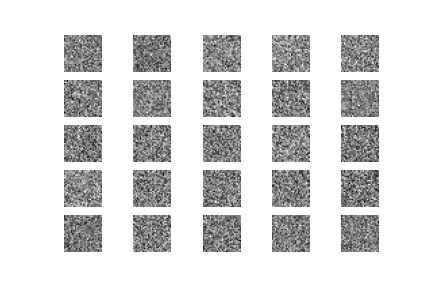

* **At Epoch-20000:-**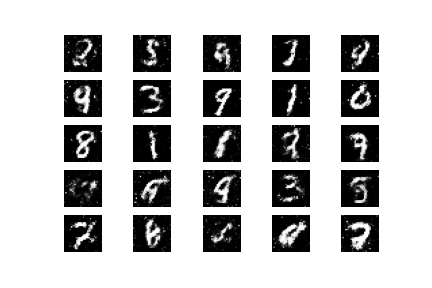

* **At Epoch-50000:-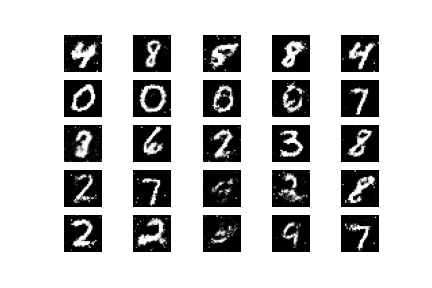**


  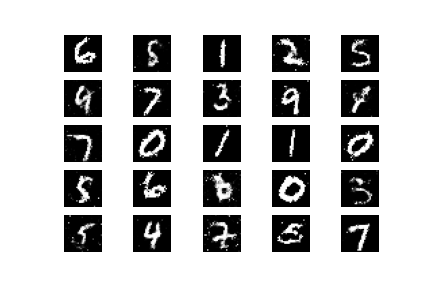